# Percent Trades Stocks

Usage in C2Score:

`- 300 * posOrZero ( %[Daily Max Leverage (Avg)]% - (  (%[Percent Trades Stocks]% * 2) + ( %[Percent Trades Futures]% * 3.5) + ( %[Percent Trades Options]% * 3) + ( %[Percent Trades Forex]% * 5) ) )
`

In [1]:
source("JupyterUtils.R")
source("C2ScoreHypothesisPresentation.R")

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        7022      225613      0.0000      0.0000      0.0058      0.3784      1.0000      1.0000      0.4595 


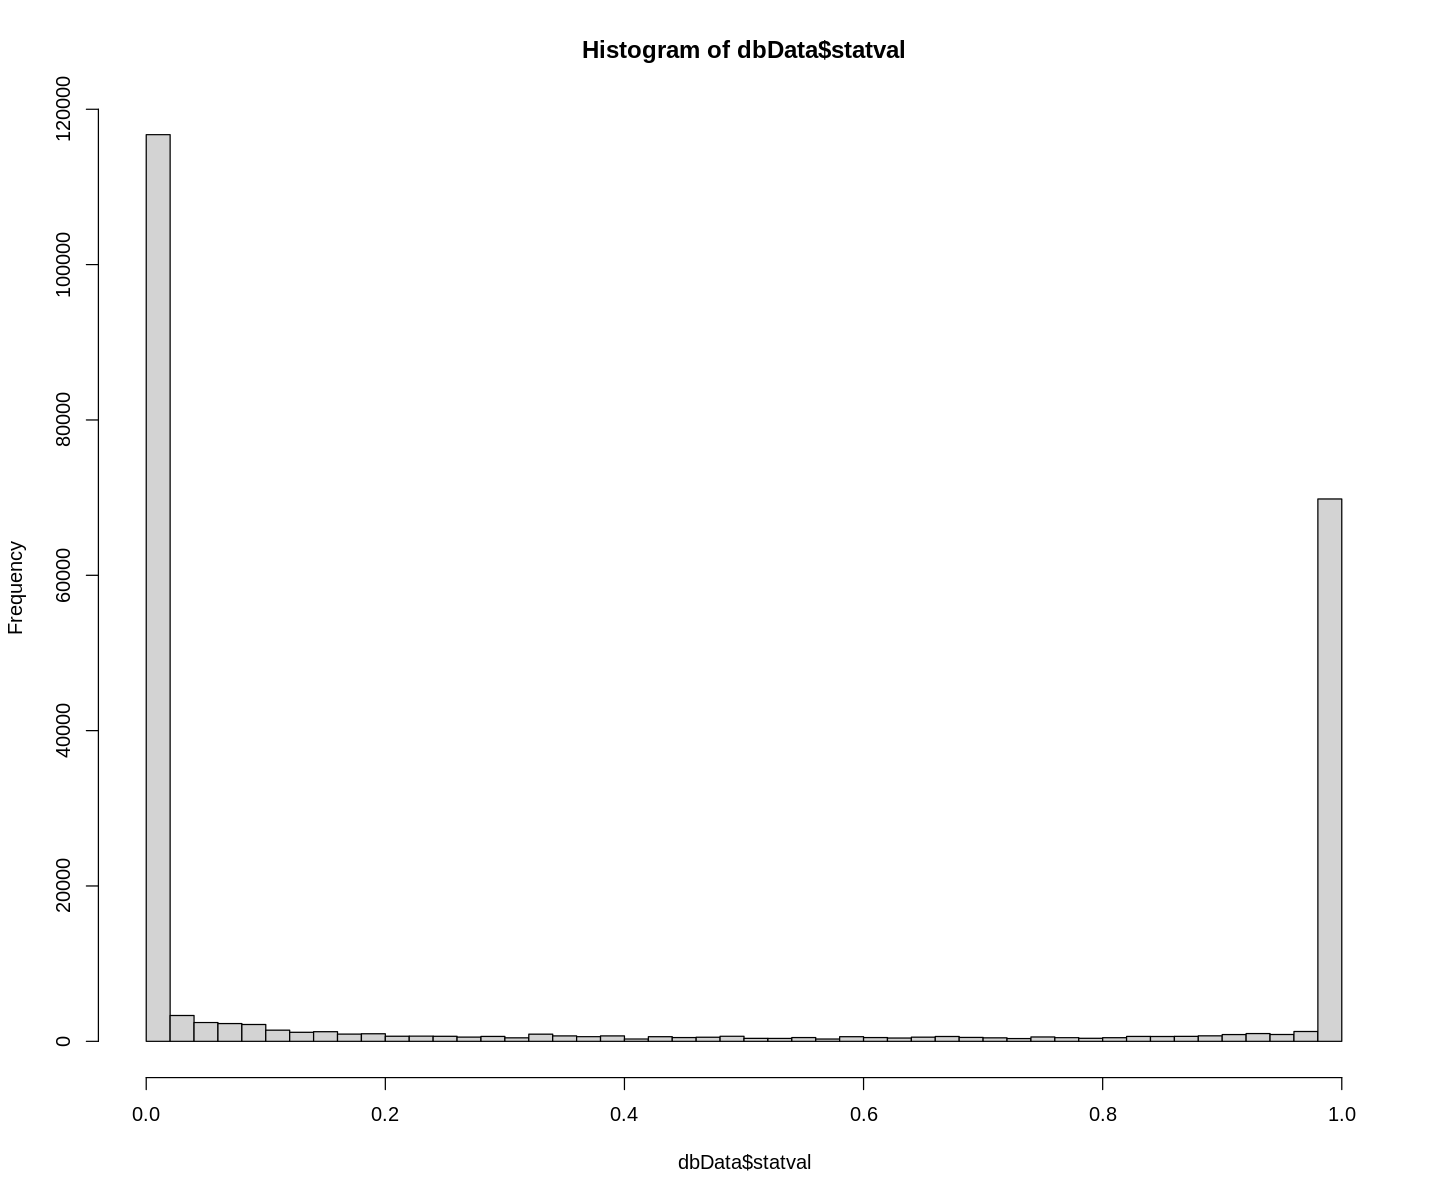

In [2]:
# What data we have.
sql = "select systemid, YYYYMMDD, statval
            from historical_stats_modern h
            where statname='stockpercent'"

dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)

- 0 means the strategy does not trade stocks. So this statistics do not affect stocks strategies. (It is constant for them.)
- 1 means the strategy trades only stocks. So this statistics do not affect stocks strategies. (It is constant for them.)
- Values between 0 and 1 are strategies trading stocks and other instruments.

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1913      262960      1.0000      5.0000      5.0000      4.3791      5.0000      5.0000      1.3205 


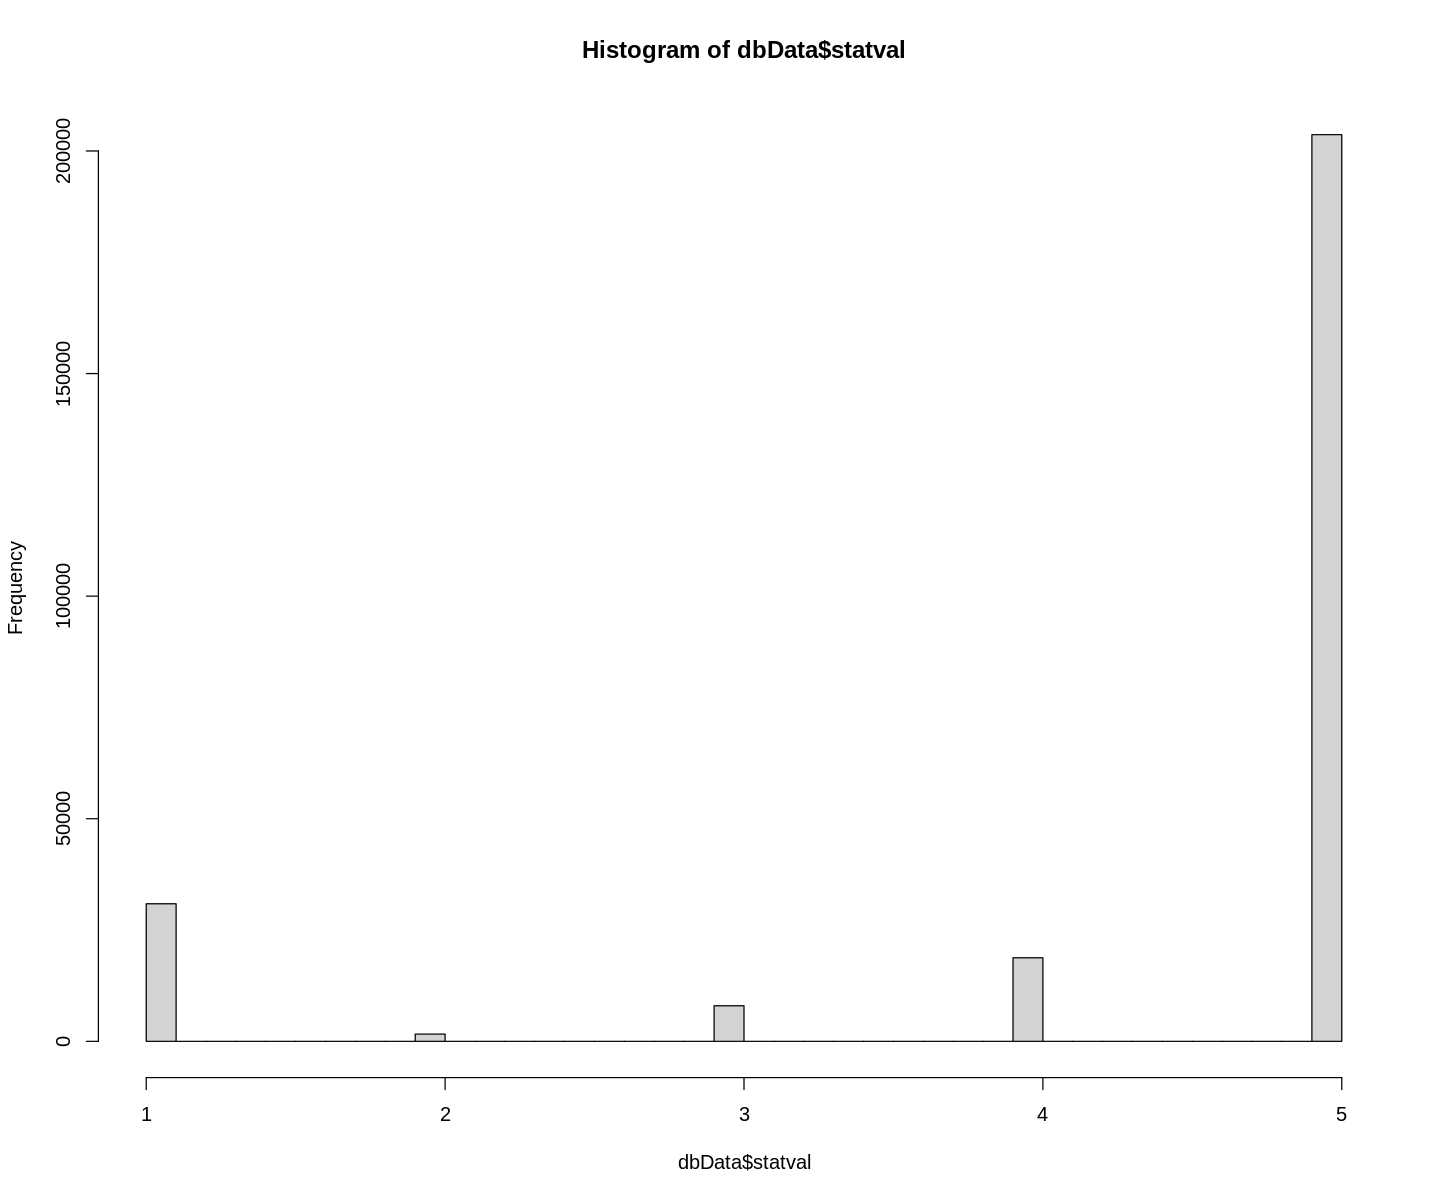

In [3]:
# Let's investigate strategies trading just one type of the instrument

# Join with our cleaned data
sql = "select 
case  
when  statname = 'stockpercent' and statval = 1 then 1
when  statname = 'optionpercent' and statval = 1 then 2
when  statname = 'forexpercent' and statval = 1 then 3
when  statname = 'futurespercent' and statval = 1 then 4
else 5 -- ALL TYPES OF MIXED STRATEGIES
end as statval,
eq.*
from ReturnsDataInIntervalsCleanedSkip090 eq
join historical_stats_modern h on h.systemid=eq.systemid 
    and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
    and statname in ('stockpercent','optionpercent','forexpercent','futurespercent') 
    and (statval = 0 or statval = 1)"

dbData = getC2ScoreDbData(sql)
overview(dbData)
hist(dbData$statval,breaks=50)



We have calculated and stored the whole population statistics of strategies daily returns after 7, 14, ..., 360 days. Day after day. Now, we selected a particular statistics data (a sample) from the whole population. Collective2 data are joined with a cleaned strategies set used for the population calculations. We want to know, if the average of returns of the sample is significantly higher than an average of returns of the whole population. A significance level is  0.05 .

The following table contains this hypothesis tests for defined stats intervals and all 7, 14, ..., 360 days time intervals.


Descriptive stats of all data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1913      262960      1.0000      5.0000      5.0000      4.3791      5.0000      5.0000      1.3205 



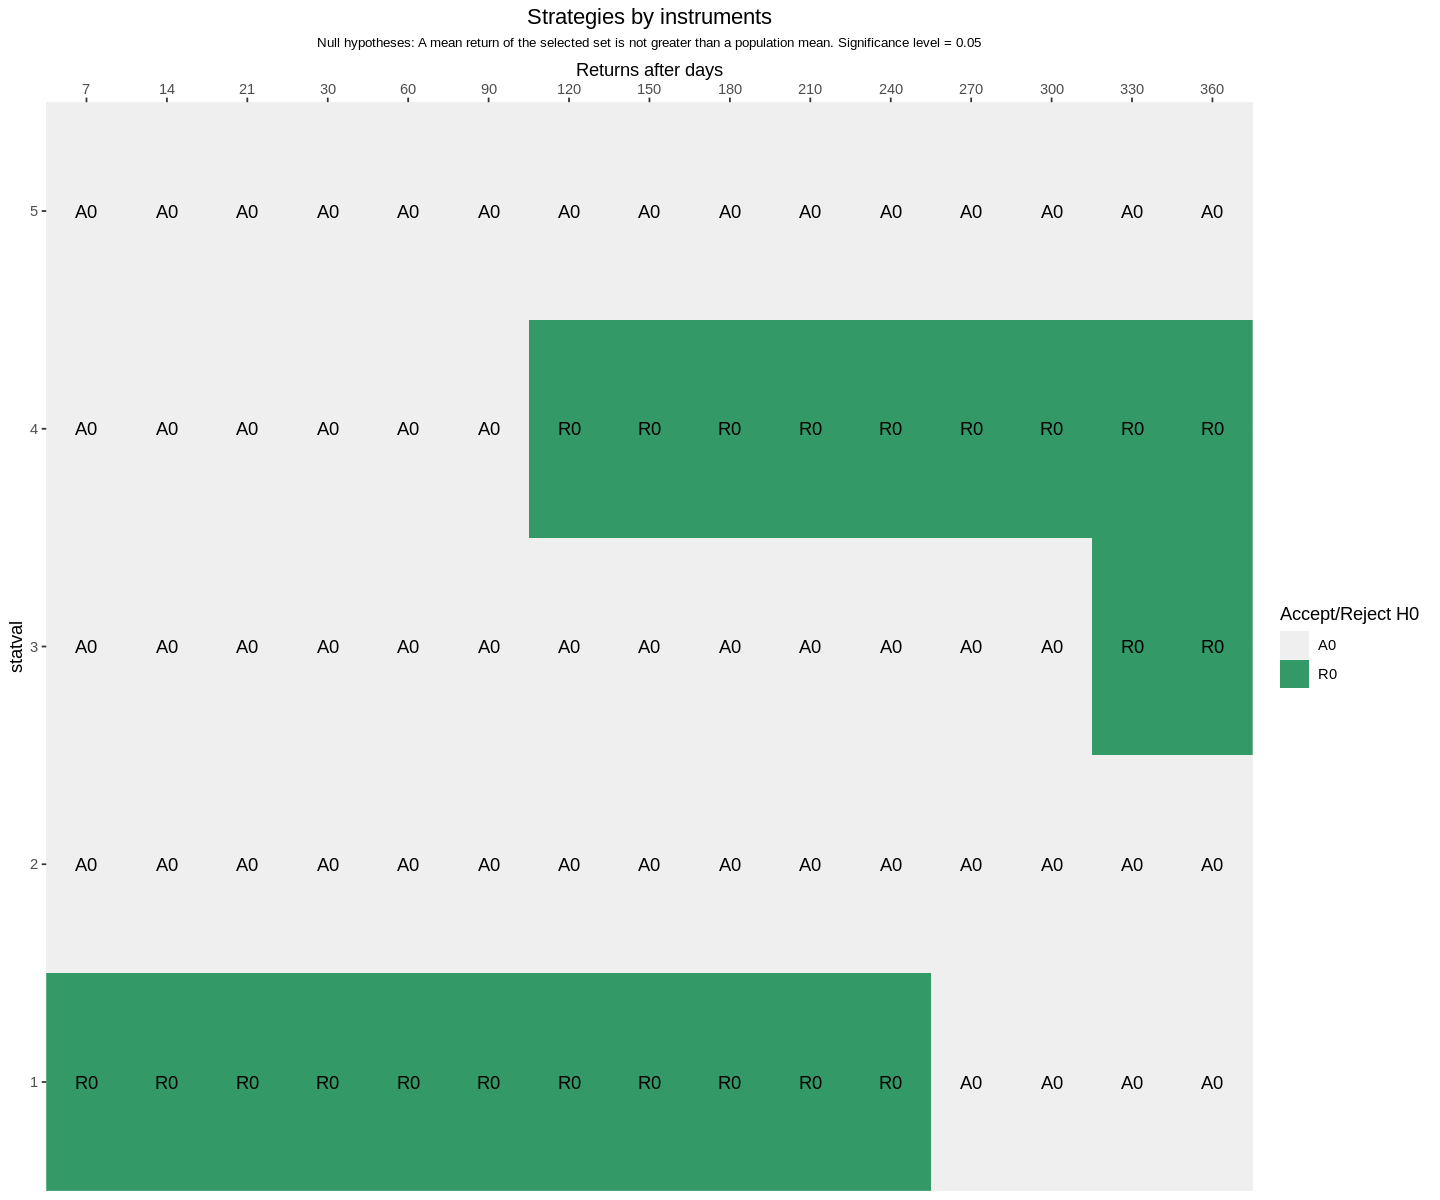

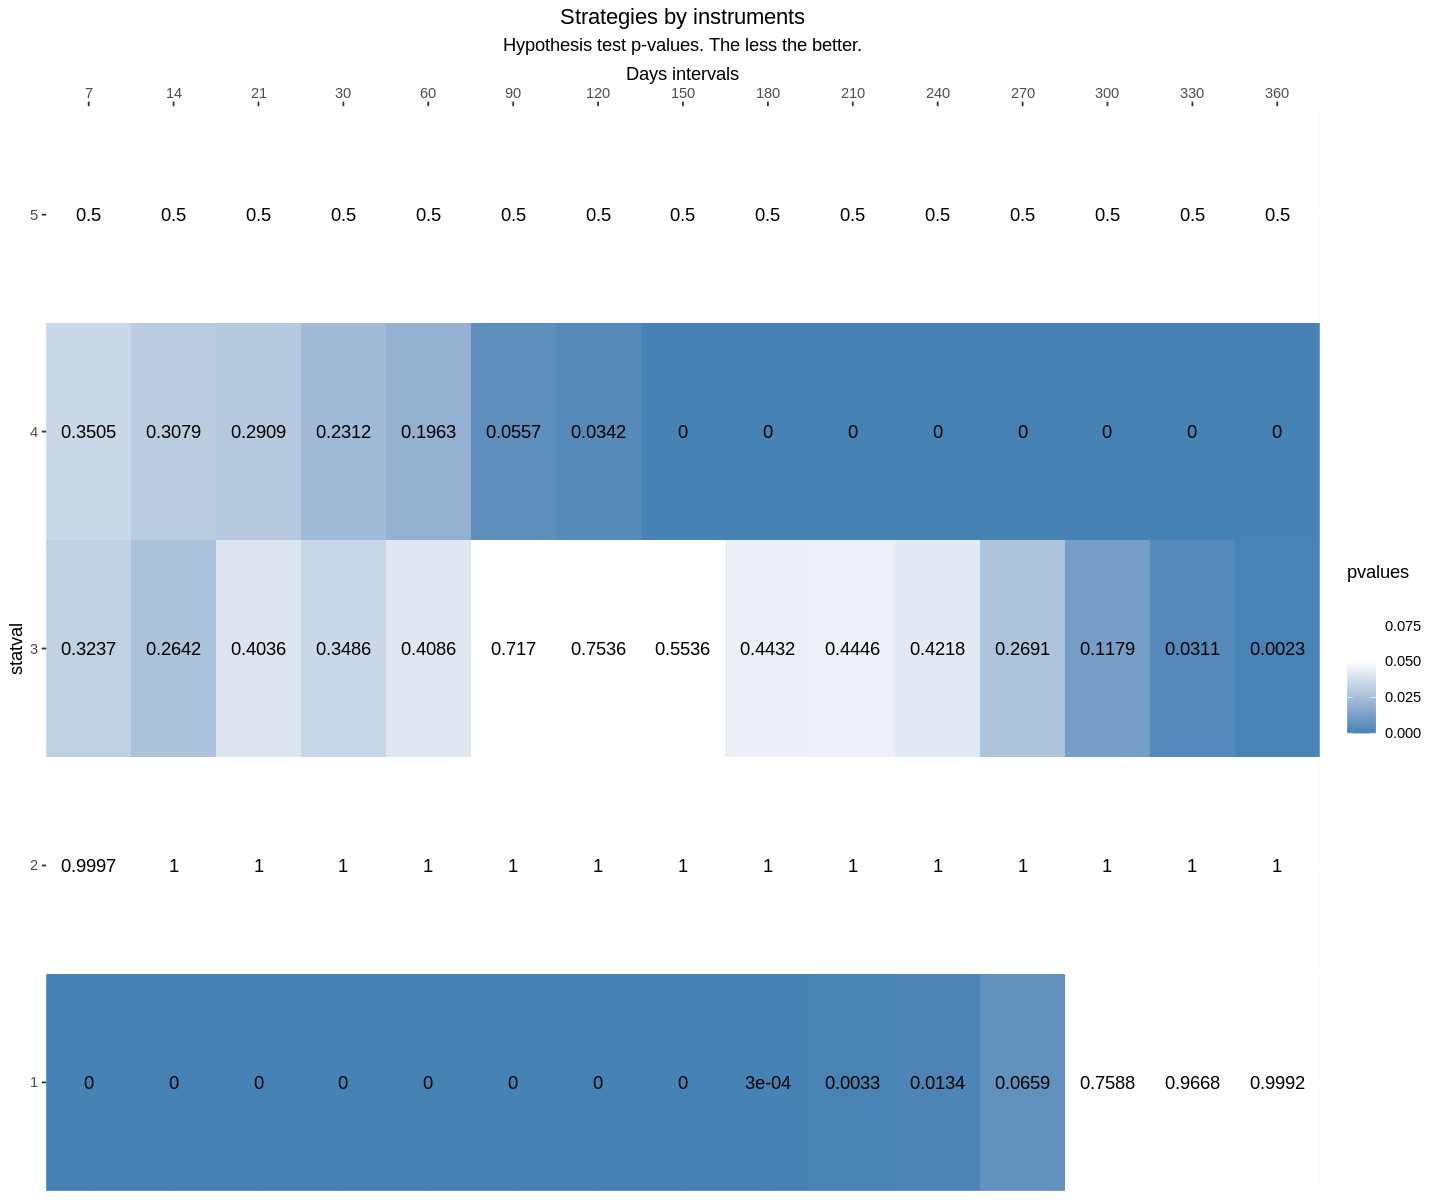

In [4]:
experiment = list(
  name = "Strategies by instruments",
  description = "Strategies by instruments",
  sqlText = sql, # the latest sql above
  attributeName = "statval",
  attributeSteps = seq(from = 1, to = 5, by = 1)) 

result = makeExperiment(experiment, sampleData = dbData)


Hypothesis test of sample standard deviation.

Alternative hypothesis: The sample standard deviation is less than the population SD.


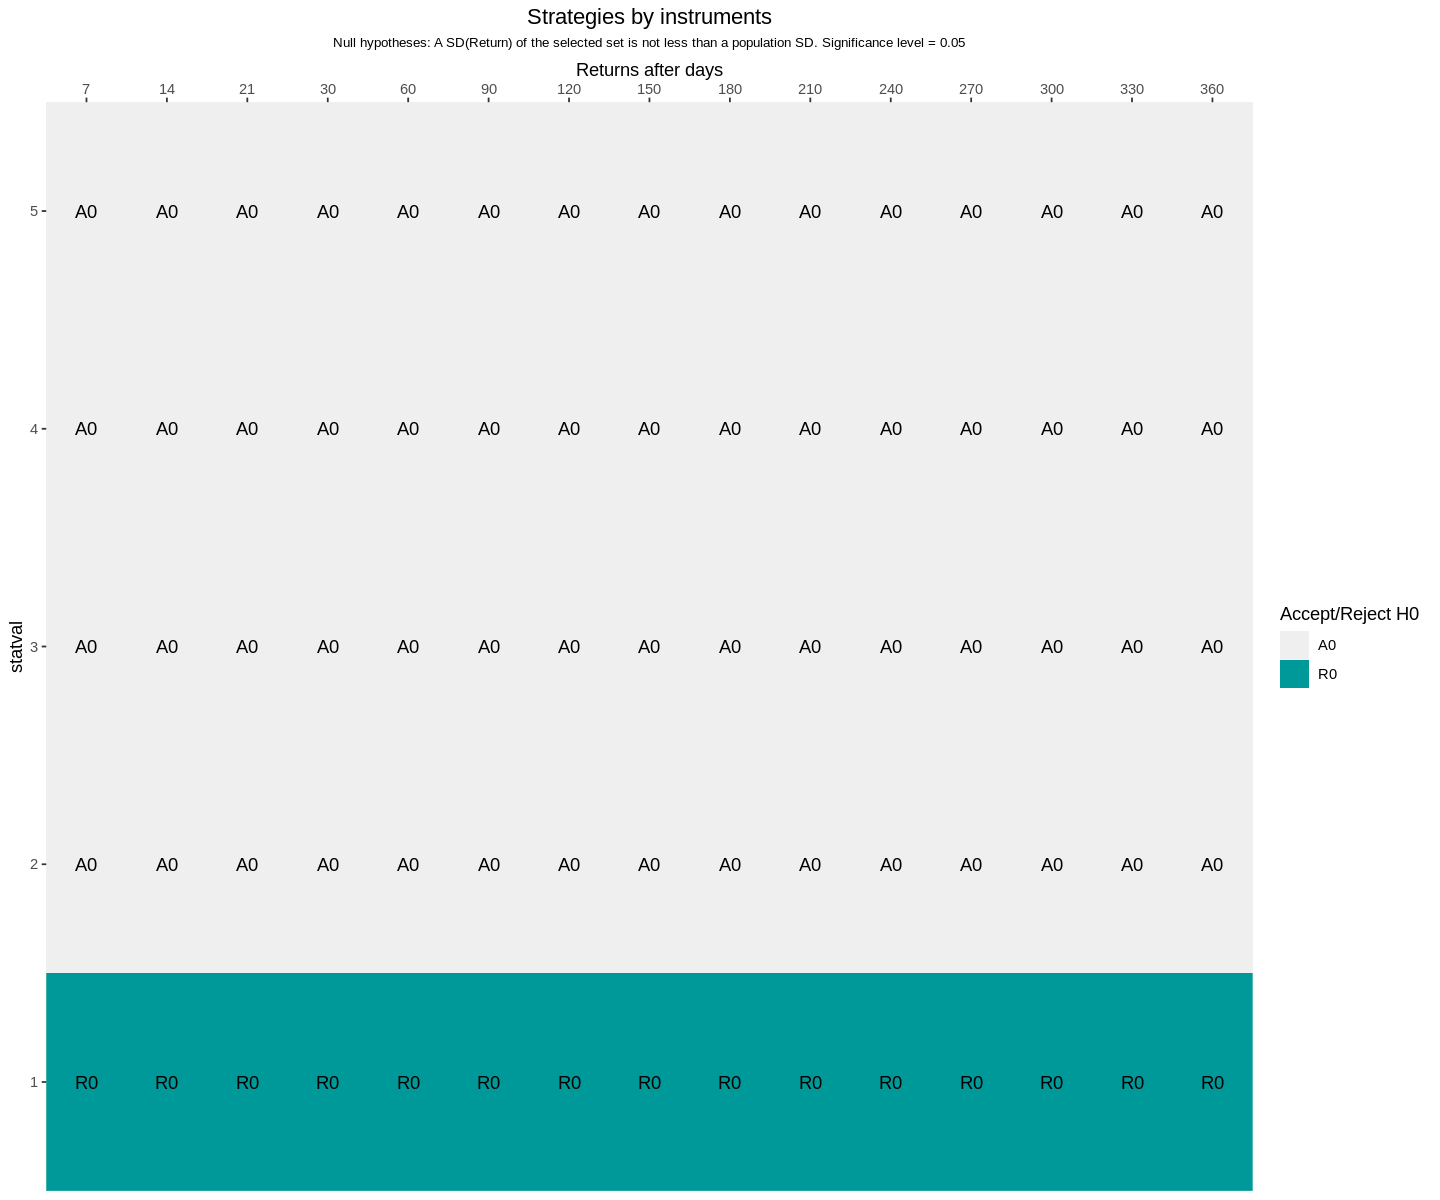

In [5]:
showSDLessHypothesisTest(experiment, result)

In [6]:
showObservationsCounts(experiment, result)


The following table contains numbers of observations in the used statistics intervals.
A number of observations in the sample is an important part of the hypothesis testing. Be careful if it is low (less than 30).
Collective2 data are calculated in 7-days intervals. It means we have less observations which decreases hypotesis testing reliability. Use daily data tests if available.
Numbers of observations shown in this table are NOT numbers of C2 strategies! Every strategy can have many observations in any statistics interval. That is what is shown here.


Selection,Obs007,Obs014,Obs021,Obs030,Obs060,Obs090,Obs120,Obs150,Obs180,Obs210,Obs240,Obs270,Obs300,Obs330,Obs360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4 <= statval < 5,18359,17947,17531,16977,15051,12902,11102,9610,8380,7405,6504,5711,5034,4439,3901
3 <= statval < 4,7793,7601,7410,7147,6272,5325,4572,3961,3480,3099,2747,2415,2126,1865,1639
2 <= statval < 3,1591,1551,1509,1458,1261,1009,795,621,511,444,381,334,298,269,235
1 <= statval < 2,30433,29960,29479,28813,26483,23543,21176,19127,17273,15791,14399,13172,12016,11012,10073



SampleMetricValue minus PopulationMetricValue

This table shows differences between metric values calculated for the whole population and the current sample metric values. (See the chapter 'Population statistics'.)
This is different from our hypothesis test. Our hypothesis test tests an (alternative) hypothesis 'Is a mean of the sample greater than a mean of the population?'
But our metric is 'Mean divided by SD'. So the standard deviation plays a role in it.
Our metric is greater when a numerator is greater and/or denominator is less. It is up to you what you prefer.



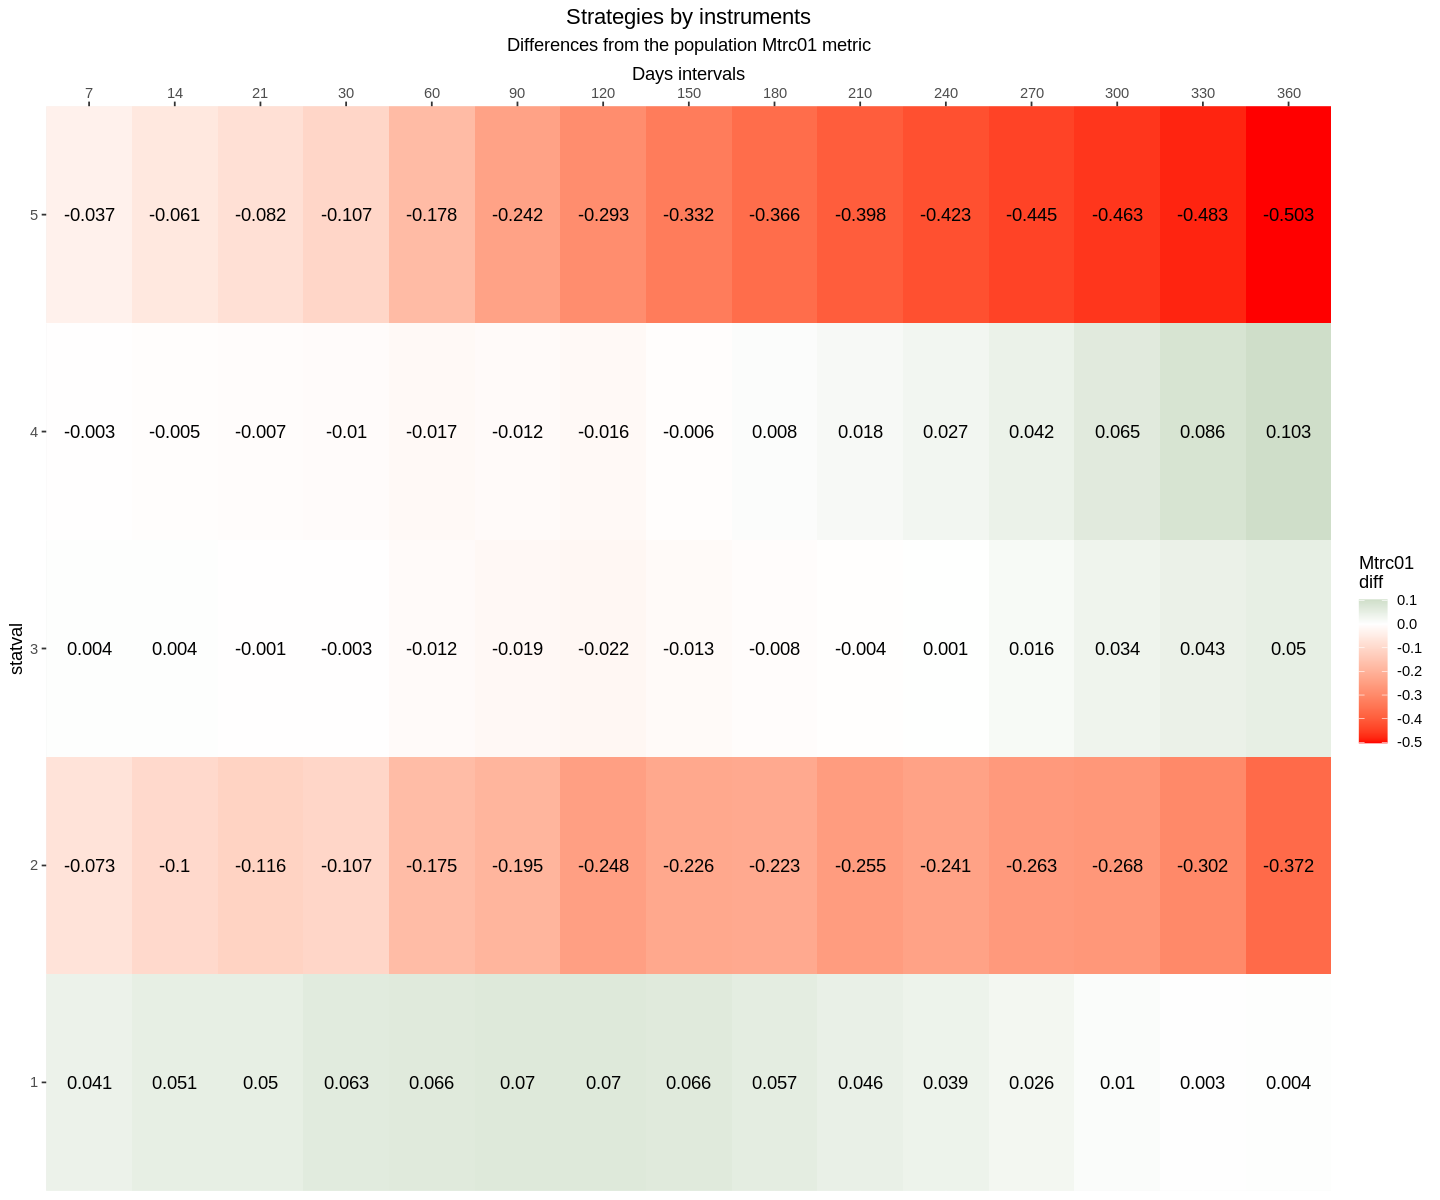

In [7]:
showMetricDifferences(experiment, result)

In [8]:
showSystemsCounts(experiment, result) 



Numbers of strategies observed in defined intervals.

Selection,Sys007,Sys014,Sys021,Sys030,Sys060,Sys090,Sys120,Sys150,Sys180,Sys210,Sys240,Sys270,Sys300,Sys330,Sys360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4 <= statval < 5,578,575,573,567,558,495,406,331,274,245,214,179,158,142,121
3 <= statval < 4,253,250,249,246,240,217,163,130,105,94,86,79,70,62,53
2 <= statval < 3,115,115,111,110,105,98,74,53,36,30,25,20,20,19,17
1 <= statval < 2,786,784,784,780,768,690,582,493,420,384,333,300,266,250,218


### Discussion

Let's repeat what we are looking at here:

- 1 = purely stock strategies
- 2 = purely options strategies
- 3 = purely forex strategies
- 4 = purely futures strategies

Number 5 is everything else.  

Alternative hypothesis is accepted for stocks (up to 210 days with p-value 0.0033) and for futures strategies (from 150 to 360 days). The metric is better in those cases.

Alternative hypothesis is accepted also for options strategies, but only for 330 and 360 days returns. But the metric is lower which means that volatility is higher.

I am not sure what the row 5 in the `SampleMetricValue minus PopulationMetricValue` table means. We have categorical data in this case and the software is developed for numerical continuous data. So be careful interpreting it.
